<a href="https://colab.research.google.com/github/babyraggge/ml-algorithms/blob/main/02_kmean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание 1

- Реализовать kmeans
- Визуализировать сходимость центров кластеров
- Оценить $SSE$ для значений $k = 1, \ldots, 10$ и построить график зависимости $SSE$ от количества кластеров.

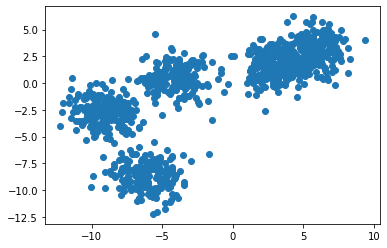

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from abc import ABC, abstractmethod
from collections import Counter
from sklearn.datasets import make_blobs

X, Y = make_blobs(n_samples = 1000, n_features=2, centers=5, cluster_std = 1.2, random_state=17)
plt.scatter(X[:,0], X[:,1]);

In [ ]:
class BaseEstimator(ABC):
  @abstractmethod
  def fit(self):
    pass

  @abstractmethod
  def predict(self):
    pass

In [ ]:
class KMeans(BaseEstimator):

  def __init__(self, n_clusters=3, eps=.001, max_iter=300, seed=42):
    self.n_clusters = n_clusters
    self.eps = eps
    self.max_iter = max_iter
    self.seed = seed

  def _euclidean_distance(self, obj, data):
    return np.sum((obj - data) ** 2, axis=1)

  def _init_centroids(self, data, n_clusters, seed):
    np.random.seed(self.seed)
    init_indices = np.random.choice(data.shape[0], size=n_clusters)
    return init_indices

  def _calculate_clusters(self, data, centroids):
    data_clusters = []
    # Для кажого объекта находим расстояние до всех центроидов
    for obj in data:
        distances = self._euclidean_distance(obj, centroids)
        # Ближайший центроид определит принадлежность к объекта конкретному кластеру
        data_clusters.append(np.argmin(distances))

    return data_clusters

  def _sse(self, data, centroid):
    return np.sum((data - centroid) **2)

  def fit(self, data):
    centroids_inds = self._init_centroids(data, self.n_clusters, self.seed)
    self.centroids = data[centroids_inds, :]

    for i in range(self.max_iter):

      errors_list = []
      data_clusters = self._calculate_clusters(data, self.centroids)

      # Сохраняем массив с центроидами в отдельную переменную
      old_centroids = self.centroids.copy()
      # Определим новые центроиды как среднее всех объектов в кластере
      for cluster in range(self.n_clusters):
        # Получаем объекты данных для текущего кластера
        data_in_cluster = data[np.where(np.array(data_clusters) == cluster)]
      
        # Усредняем объекты в кластере: получаем новый центроид для текущего кластера
        self.centroids[cluster] = data_in_cluster.mean(axis=0)

        # Расчитываем текущую SSE для данного кластера
        errors_list.append(self._sse(data_in_cluster, self.centroids[cluster]))

      # Усредняем ошибку по всем кластерам
      self.SSE = np.array(errors_list).mean()
      # Условие на выход при схождении: если разность между старыми и новыми центроидами не привышает заданную точность,
      # то выходим из обучающего цикла
      if (abs(self.centroids - old_centroids < self.eps).all()):
        return

    return

  def predict(self, data):
    data_clusters = self._calculate_clusters(data, self.centroids)
    return np.array(data_clusters)

  def fit_predict(self, data):
    self.fit(data)
    return self.predict(data)


In [ ]:
km = KMeans()
km.fit(X)
clusters = km.predict(X)

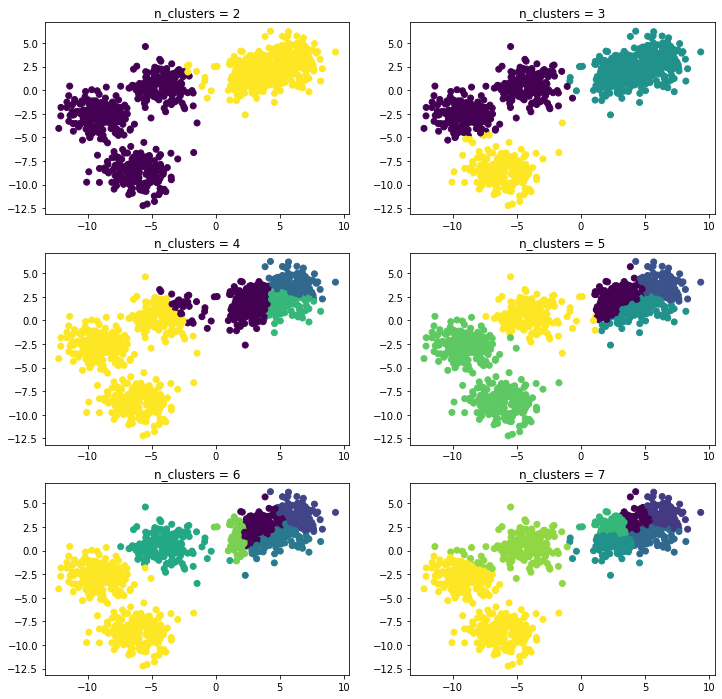

In [ ]:
plt.figure(figsize=(12, 12))
for n_c in range(2, 8):
    k_means = KMeans(n_clusters=n_c)
    clusters = k_means.fit_predict(X)
    plt.subplot(3, 2, n_c-1)
    plt.scatter(X[:, 0], X[:, 1], c=clusters)
    plt.title('n_clusters = {}'.format(n_c))
plt.show()

In [ ]:
def drawSSEPlotManual(data, n_clusters=8, max_iter=300, eps=.001, seed=42):
    sse_values = []
    for i in range(1, n_clusters+1):
        km = KMeans(n_clusters=i, max_iter=max_iter, eps=eps, seed=seed)
        km.fit_predict(data)
        sse_values.append(km.SSE)
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(range(1, n_clusters+1), sse_values, color='green')
    plt.xlabel('No. of Clusters', fontsize=15)
    plt.ylabel('SSE', fontsize=15)
    plt.title('SSE vs No. Of Clusters', fontsize=15)
    plt.grid()
    plt.show()

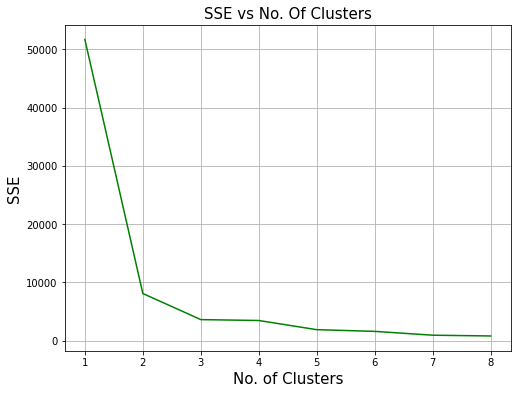

In [ ]:
drawSSEPlotManual(X)

# Задание 2

Исследуйте данные с помощью pandas. Посмотрите на признаки и их распределения. (Например, постройте график распределения автомобилей по годам, типу топлива и т.д.)
1. Кластеризуйте данные с помощью KMeans из sklearn.clustering. 
2. Кластеризуйте данные с помощью KMeans из sklearn.clustering. Найдите оптимальное число кластеров
3. Произведите анализ получившихся кластеров:




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

data_url = 'https://raw.githubusercontent.com/julia-komleva/ml-course-2021/main/data/2.csv'
df = pd.read_csv(data_url, encoding='cp1251')
df = df.drop(columns=['Модель', 'Цвет'])
df.head()

,Марка,Год,Состояние,Пробег,Объем,Топливо,Мощность,Кузов,Привод,КПП,Руль,Хозяев в ПТС,Цена
0,Volkswagen,2013.0,БУ,42000.0,1200.0,бензин,105.0,хэтчбек,передний,автомат,левый,1 владелец,689196.0
1,Skoda,2012.0,БУ,62000.0,1800.0,бензин,152.0,кроссовер,полный,механика,левый,1 владелец,639196.0
2,Renault,2015.0,БУ,4700.0,1600.0,бензин,106.0,хэтчбек,передний,механика,левый,1 владелец,629196.0
3,Nissan,2012.0,БУ,70000.0,1600.0,бензин,110.0,хэтчбек,передний,автомат,левый,1 владелец,479196.0
4,УАЗ,2014.0,БУ,50000.0,2700.0,бензин,128.0,внедорожник,полный,механика,левый,1 владелец,599196.0


In [2]:
df["Марка"].value_counts()

ВАЗ                5497
Toyota             2700
Nissan             2064
Hyundai            1897
Volkswagen         1885
                   ... 
Samand                1
Scion                 1
GMC                   1
Renault Samsung       1
Hawtai                1
Name: Марка, Length: 92, dtype: int64

In [3]:
for col in df.columns:
  print(f"{col}: {df[col].nunique()}")

Марка: 92
Год: 28
Состояние: 1
Пробег: 3443
Объем: 45
Топливо: 5
Мощность: 303
Кузов: 11
Привод: 3
КПП: 4
Руль: 2
Хозяев в ПТС: 3
Цена: 1577


In [4]:
df.drop("Состояние", axis=1, inplace=True) # Дисперсия 0, зачем такой признак вообще нужен

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35019 entries, 0 to 61065
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Марка         35019 non-null  object 
 1   Год           35019 non-null  float64
 2   Пробег        35019 non-null  float64
 3   Объем         35019 non-null  float64
 4   Топливо       35019 non-null  object 
 5   Мощность      35019 non-null  float64
 6   Кузов         35019 non-null  object 
 7   Привод        35019 non-null  object 
 8   КПП           35019 non-null  object 
 9   Руль          35019 non-null  object 
 10  Хозяев в ПТС  35019 non-null  object 
 11  Цена          35019 non-null  float64
dtypes: float64(5), object(7)
memory usage: 3.5+ MB


In [6]:
num_features = [col for col in df.columns if df[col].dtype == "float64"]
cat_features = [col for col in df.columns if df[col].dtype == "object"]

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)])

In [8]:
def drawSSEPlot(df, n_clusters=8, max_iter=300, tol=1e-04, init='k-means++', n_init=10):
    inertia_values = []
    for i in range(1, n_clusters+1):
        km = KMeans(n_clusters=i, max_iter=max_iter, tol=tol, init=init, n_init=n_init, random_state=1)
        km.fit_predict(df)
        inertia_values.append(km.inertia_)
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(range(1, n_clusters+1), inertia_values, color='red')
    plt.xlabel('No. of Clusters', fontsize=15)
    plt.ylabel('SSE / Inertia', fontsize=15)
    plt.title('SSE / Inertia vs No. Of Clusters', fontsize=15)
    plt.grid()
    plt.show()

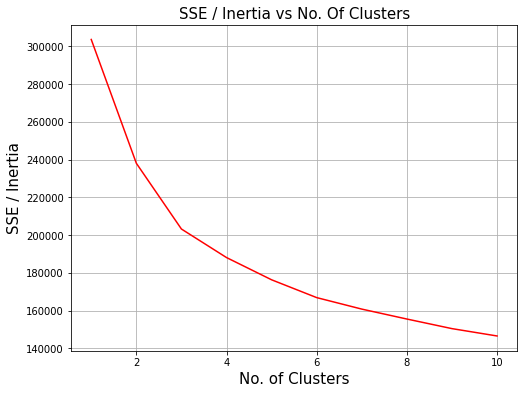

In [9]:
prep_data = preprocessor.fit_transform(df).toarray()
drawSSEPlot(prep_data, 10)

In [10]:
# kmean_pipeline = Pipeline(steps=[
#                       ('preprocessor', preprocessor),
#                       ('clusterizer', KMeans(n_clusters=6))]
#                       )

In [11]:
def get_clusterization_report_labels(df, clusters):
  df['cluster'] = clusters
  df_enc = df.copy(deep=True)
  labels = []
  for feature in cat_features:
    lenc = LabelEncoder()
    df_enc[feature] = lenc.fit_transform(df[feature])
    labels.append({i : f for i, f in enumerate(lenc.classes_.tolist())})

  res = df_enc.groupby(by="cluster").median()

  for feature, dictinary in zip(cat_features, labels):
    res[feature] = res[feature].map(dictinary)

  return res

In [12]:
km = KMeans(n_clusters=3)
clusters = km.fit_predict(prep_data)
rep = get_clusterization_report_labels(df, clusters)

In [13]:
# Если использовать 3 кластера, то полученные результаты можно интерпретировать так:
  # 1. Отностительно свежие азиатские и отечественные автомобили
  # 2. Премиум автомобили
  # 3. Старые европейские и отечественные автомобили с большим количеством владельцев
rep

,Марка,Год,Пробег,Объем,Топливо,Мощность,Кузов,Привод,КПП,Руль,Хозяев в ПТС,Цена
cluster,,,,,,,,,,,,
0,Peugeot,2003.0,178727.0,1600.0,бензин,102.0,седан,передний,механика,левый,3 и более,180000.0
1,Mercedes-Benz,2010.0,106000.0,2500.0,бензин,201.0,кроссовер,полный,автомат,левый,2 владельца,950000.0
2,Nissan,2011.0,82000.0,1600.0,бензин,107.0,седан,передний,механика,левый,2 владельца,405000.0


In [36]:
df_c = df.copy()
df_c['cluster'] = clusters
top_brands = df_c['Марка'].value_counts()[:15].index

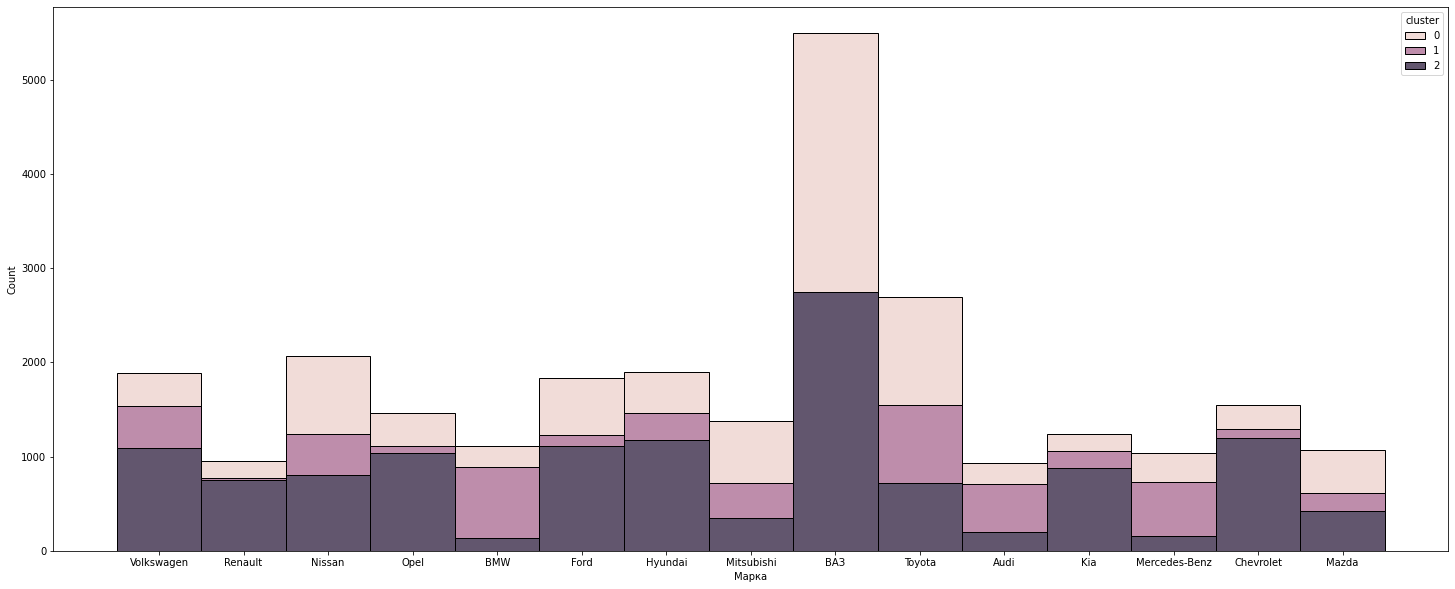

In [46]:
fig, ax = plt.subplots(figsize=(25, 10))
sns.histplot(data=df_c[df_c['Марка'].isin(top_brands)], x="Марка", hue='cluster', multiple='stack', color=['Set1'] , ax=ax)